In [249]:
import pandas as pd
import numpy as np
import keras
import shap

In [250]:
elodata = pd.read_csv("https://raw.githubusercontent.com/LouZhou1/ricedatathon2023/main/baseballwelo.csv")
fatiguedata = pd.read_csv("https://raw.githubusercontent.com/LouZhou1/ricedatathon2023/main/training_data.csv")
fatiguedata.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'game_date', 'home_team', 'away_team',
       'is_day_game', 'home_score', 'away_score', 'venue', 'venue_name',
       'city', 'state', 'home_pa', 'home_1b', 'home_2b', 'home_3b', 'home_hr',
       'home_fo', 'home_so', 'home_bb', 'home_hbp', 'away_pa', 'away_1b',
       'away_2b', 'away_3b', 'away_hr', 'away_fo', 'away_so', 'away_bb',
       'away_hbp', 'year', 'month', 'day', 'time_zone', 'latitude',
       'longitude', 'home_team_dist', 'away_team_dist', 'time_zone_num',
       'time_zone_diff_home', 'time_zone_diff_away', 'road_days',
       'road_days.1', 'is_east_home', 'is_east_away'],
      dtype='object')

In [252]:
fulldata = pd.merge(fatiguedata, elodata, on = ["Unnamed: 0"])
fulldata.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'game_date_x', 'home_team_x',
       'away_team_x', 'is_day_game_x', 'home_score_x', 'away_score_x',
       'venue_x', 'venue_name_x', 'city_x', 'state_x', 'home_pa_x',
       'home_1b_x', 'home_2b_x', 'home_3b_x', 'home_hr_x', 'home_fo_x',
       'home_so_x', 'home_bb_x', 'home_hbp_x', 'away_pa_x', 'away_1b_x',
       'away_2b_x', 'away_3b_x', 'away_hr_x', 'away_fo_x', 'away_so_x',
       'away_bb_x', 'away_hbp_x', 'year_x', 'month_x', 'day_x', 'time_zone',
       'latitude', 'longitude', 'home_team_dist', 'away_team_dist',
       'time_zone_num', 'time_zone_diff_home', 'time_zone_diff_away',
       'road_days', 'road_days.1', 'is_east_home', 'is_east_away', 'level_0',
       'index', 'game_date_y', 'home_team_y', 'away_team_y', 'is_day_game_y',
       'home_score_y', 'away_score_y', 'venue_y', 'venue_name_y', 'city_y',
       'state_y', 'home_pa_y', 'home_1b_y', 'home_2b_y', 'home_3b_y',
       'home_hr_y', 'home_fo_y', 'home_so_y', 'home_bb_y', '

In [253]:
useful = fulldata[['home_final_elo', 'away_final_elo', 'time_zone_diff_home', 'time_zone_diff_away','home_team_dist', 'away_team_dist', 'HomeWin', 'road_days.1','is_east_home', 'is_east_away']].dropna()

In [254]:
useful

,home_final_elo,away_final_elo,time_zone_diff_home,time_zone_diff_away,home_team_dist,away_team_dist,HomeWin,road_days.1,is_east_home,is_east_away
0,1539.047683,1435.514505,12,13,6736.443955,6295.151334,0,1,1,1
1,1435.514505,1539.047683,0,0,0.000000,0.000000,0,1,0,0
2,1535.982363,1502.242683,0,2,0.000000,1209.188844,1,1,0,1
3,1480.784218,1566.733890,0,3,0.000000,2589.167669,1,1,0,1
4,1432.516520,1517.531178,0,3,0.000000,2463.256764,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
56764,1416.380906,1532.191119,0,0,0.000000,0.000000,0,1,0,0
56765,1482.297756,1482.298803,0,0,0.000000,0.000000,1,1,0,0
56766,1421.425693,1506.600861,0,0,0.000000,0.000000,1,1,0,0
56767,1536.858052,1519.721648,0,0,0.000000,0.000000,1,1,0,0


In [255]:
useful["Circadian_Advantage"] = useful["time_zone_diff_home"] - useful["time_zone_diff_away"]
useful["Distance_Advantage"] = useful["home_team_dist"] - useful["away_team_dist"]
useful["EloDiff"] = useful["home_final_elo"] - useful["away_final_elo"]
useful["EastWestDiff"] = useful['is_east_home'] - useful['is_east_away']

In [256]:
explanatory = useful[['EloDiff', "Circadian_Advantage", "Distance_Advantage", "road_days.1", "EastWestDiff"]]
dependent = useful[["HomeWin"]]

In [257]:
explanatory

,EloDiff,Circadian_Advantage,Distance_Advantage,road_days.1,EastWestDiff
0,103.533178,-1,441.292621,1,0
1,-103.533178,0,0.000000,1,0
2,33.739680,-2,-1209.188844,1,-1
3,-85.949672,-3,-2589.167669,1,-1
4,-85.014658,-3,-2463.256764,1,-1
...,...,...,...,...,...
56764,-115.810212,0,0.000000,1,0
56765,-0.001047,0,0.000000,1,0
56766,-85.175169,0,0.000000,1,0
56767,17.136404,0,0.000000,1,0


In [281]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
exp_train, exp_test, dep_train, dep_test = train_test_split(explanatory, dependent, test_size=0.2, random_state=42)
xgb = GradientBoostingClassifier(n_estimators = 10)
xgb.fit(exp_train, dep_train)
print(roc_auc_score(dep_test, xgb.predict_proba(exp_test)[:, 1]))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.6116329753298311


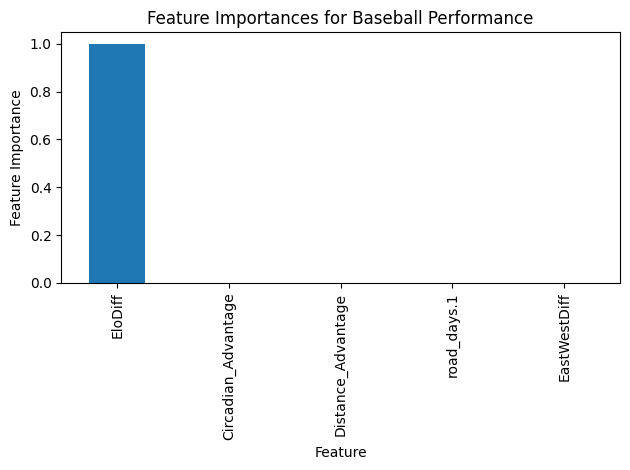

In [283]:
import matplotlib.pyplot as plt
feature_importances = xgb.feature_importances_
importances = pd.Series(feature_importances, index=exp_train.columns)
fig, ax = plt.subplots()
importances.plot.bar()
ax.set_title("Feature Importances for Baseball Performance")
ax.set_ylabel("Feature Importance")
ax.set_xlabel("Feature")
fig.tight_layout()